## Introduction

This project is written by Rui Bai(rb3454) and Yichi Liu (yl4327). The logic is based on the [paper](https://arxiv.org/abs/1703.02442). We used data from [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) which contains several slides from [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset.

This script will generate heapmap inference for both single scale model and multi scale model (which will consider surrounding contexts). 3 slides image is used for this part: 091, 096, 110.

## Setting up

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,313 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpac

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

import random
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf



In [ ]:
BATCH_SIZE = 32
PATCH_SIZE = 299
CENTER_SIZE = 128

# change para
levels = 'level12'
level1 = 'level1'
level2 = 'level2'

train_dir_l1 = '/content/gdrive/My Drive/applied deep learning/final pj/'+levels + '/' + level1+'/train'
train_dir_l2 = '/content/gdrive/My Drive/applied deep learning/final pj/'+levels + '/' + level2+'/train'
val_dir_l1 = '/content/gdrive/My Drive/applied deep learning/final pj/'+levels + '/' + level1+'/validation'
val_dir_l2 = '/content/gdrive/My Drive/applied deep learning/final pj/'+levels + '/' + level2+'/validation'

result_save_dir = '/content/gdrive/My Drive/applied deep learning/final pj/result'

single_scale_inception_model_fix_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_fix.h5'
single_scale_inception_model_fix_history_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_fix_history.csv'
single_scale_inception_model_fix_plot_acc_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_fix_acc.png'
single_scale_inception_model_fix_plot_loss_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_fix_loss.png'

single_scale_inception_model_unfix_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_unfix.h5'
single_scale_inception_model_unfix_history_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_unfix_history.csv'
single_scale_inception_model_unfix_plot_acc_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_unfix_acc.png'
single_scale_inception_model_unfix_plot_loss_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_unfix_loss.png'

multi_scale_inception_model_fix_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_fix.h5'
multi_scale_inception_model_fix_history_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_fix_history.csv'
multi_scale_inception_model_fix_plot_acc_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_fix_acc.png'
multi_scale_inception_model_fix_plot_loss_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_fix_loss.png'

multi_scale_inception_model_unfix_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_fix.h5'
multi_scale_inception_model_unfix_history_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_unfix_history.csv'
multi_scale_inception_model_unfix_plot_acc_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_unfix_acc.png'
multi_scale_inception_model_unfix_plot_loss_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_unfix_loss.png'

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

## Heatmap Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
single_scale_inception_model = tf.keras.models.load_model(single_scale_inception_model_fix_save)
single_scale_inception_model_2 = tf.keras.models.load_model(single_scale_inception_model_unfix_save)
multi_scale_inception_model = tf.keras.models.load_model(multi_scale_inception_model_fix_save)
multi_scale_inception_model_2 = tf.keras.models.load_model(multi_scale_inception_model_unfix_save)

In [ ]:
# same as before
def get_a_patch_from_a_slide(slide, tumor_mask, x, y, size = 299, level = 4):
  # (x,y) is the upper-left corner of the desired patch
  # return the patch for slide, tumor mask, and tissue
  
  patch_slide = read_slide(slide, x=x, y=y, level=level, width=size, height=size)
  patch_mask = read_slide(tumor_mask, x=x, y=y, level=level, width=size, height=size)[:,:,0]

  return patch_slide, patch_mask

In [ ]:
def preprocess_image(img):
  img = img.astype(float)
  img /= 255.0
  return img

In [ ]:
def get_true_label(patch_mask, size, center_size):
  '''
  get the label of the input mask image, if it contains tumor in center area, then output 1, otherwise 0
  '''
  # check if the patch contain tumor in center-size part in the reference level
  temp = int((size-center_size)/2)
  center_mask = patch_mask[temp:temp+center_size, temp:temp+center_size]
  if 1 not in center_mask:
    # if its center-size part does not contain tumor
    return 0
  else:
    return 1

In [ ]:
def center_contain_tissue(patch_image, size=PATCH_SIZE, center_size=CENTER_SIZE):
  '''
  check if the center region of this patch contains any tissue, if yes return True
  '''
  tissue_pixels = find_tissue_pixels(patch_image)
  tissue_regions = apply_mask(patch_image, tissue_pixels)

  temp = int((size-center_size)/2)
  center_region = tissue_regions[temp:temp+center_size, temp:temp+center_size]
  
  if (255,0,0) not in center_region:
    return False
  else:
    return True

In [ ]:
def heatmap_prediction_one_time(slide, tumor_mask, levels, size = 299, center_size = 128, model_train_parameter=False):
  # if it's multi-scale model prediction
  if len(levels) > 1:
    heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels = heatmap_prediction_one_time_multi_scale(slide, tumor_mask, levels, size, center_size, model_train_parameter)
  else:
    heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels = heatmap_prediction_one_time_single_scale(slide, tumor_mask, levels, size, center_size, model_train_parameter)
  return heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels

In [ ]:
def heatmap_prediction_one_time_multi_scale(slide, tumor_mask, levels, size = 299, center_size = 128, model_train_parameter=False):
  """ 
  Predict a heatmap for the input slide, using multi-scale model, single prediction
  """
  
  thres = 0.5 # threshold of probability to decide a patch contains tumor
  plot_level = 7
  scale_factor_plot = 2**plot_level

  pred_labels = []
  true_labels = []

  heatmap_x_from_list = []
  heatmap_x_to_list = []
  heatmap_y_from_list = []
  heatmap_y_to_list = []
  pred_probs_list = []

  # each time collect a batch of patches to predict together (if one by one, running time too long; if all together, RAM will crash)
  prediction_batch_size = 250
  batch_of_patches = []

  # read in slide and tumor masks
  slide_image = read_slide(slide, x=0, y=0, level=plot_level,
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])
  mask_image = read_slide(tumor_mask, x=0, y=0, level=plot_level, 
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])[:,:,0]
  
  # get tissue pixels
  tissue_pixels = find_tissue_pixels(slide_image)

  # initialize the heatmap with zeros
  heatmap = np.zeros((slide.level_dimensions[plot_level][1],slide.level_dimensions[plot_level][0]))
  heatmap_prob = np.zeros((slide.level_dimensions[plot_level][1],slide.level_dimensions[plot_level][0]))

  l1 = levels[0]
  scale_factor_l1 = 2**l1

  if model_train_parameter ==False:
    model = multi_scale_inception_model
  else:
    model =  multi_scale_inception_model_2
  l2 = levels[1]

  # get the slide size of model prediction level
  width_l1=slide.level_dimensions[l1][0]
  height_l1=slide.level_dimensions[l1][1]

  scale_factor_l2 = 2**l2
  half_patch_size = size //2

  # sliding a window through the image, step = center_size (= 128 by default) at 1st level in levels
  window_step = center_size * scale_factor_l1
  start_upper_left = (-(size - center_size)//2) * scale_factor_l1 # the start_x (== start_y) so that window's center part at (0,0)

  # to store l2 patches
  batch_of_patches_l2 = []

  for window_x in tqdm(range(start_upper_left, width_l1 * scale_factor_l1 - window_step, window_step)):
    for window_y in range(start_upper_left, height_l1 * scale_factor_l1 - window_step, window_step):

      # if this batch is full, predict them together, and clear this batch
      if len(batch_of_patches) == prediction_batch_size: 
        # predict the patches, and store the predicted probability of tumor
        pred_probs = [prob_1 for (prob_0, prob_1) in model.predict([np.asarray(batch_of_patches), np.asarray(batch_of_patches_l2)])]
        pred_probs_list += pred_probs
        for i in range(len(pred_probs)):
          prob = pred_probs[i]
          heatmap_x_from = heatmap_x_from_list[i]
          heatmap_y_from = heatmap_y_from_list[i]
          heatmap_x_to = heatmap_x_to_list[i]
          heatmap_y_to = heatmap_y_to_list[i]
          if prob >= thres:
            heatmap[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = 1
            pred_labels.append(1)
          else:
            pred_labels.append(0)
          heatmap_prob[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = prob
        # clear info for this batch to save RAM
        batch_of_patches = []
        batch_of_patches_l2 = []
        heatmap_x_from_list = []
        heatmap_y_from_list = []
        heatmap_x_to_list = []
        heatmap_y_to_list = []
        # print("Finished predicting a batch.")

      # if this batch is not full, continue to collect patches
      else:
        # get the l1 patch with upper-left corner at (window_x, window_y)
        patch_image_1, patch_mask_1 = get_a_patch_from_a_slide(slide, tumor_mask, window_x, window_y, size, level = l1)

        # only predict if it contains tissue in center region
        if center_contain_tissue(patch_image_1):
          # add this to the patches list
          img1 = preprocess_image(patch_image_1)
          batch_of_patches.append(img1)

          # get the true label of this patch
          true_label = get_true_label(patch_mask_1, size, center_size)
          true_labels.append(true_label)

          # calculate the upper-left coordinate for corresponding l2 slide, with same center as l1 patch
          center_coord = (window_x + (half_patch_size * scale_factor_l1), window_y + (half_patch_size * scale_factor_l1))
          upper_left_x_l2 = center_coord[0] - half_patch_size * scale_factor_l2
          upper_left_y_l2 = center_coord[1] - half_patch_size * scale_factor_l2
          
          # get the corresponding l2 patch
          patch_image_2, patch_mask_2 = get_a_patch_from_a_slide(slide, tumor_mask, upper_left_x_l2, upper_left_y_l2, size, level = l2)
          img2 = preprocess_image(patch_image_2)
          batch_of_patches_l2.append(img2)

          # store the area to color for this patch
          center_window_x = window_x + ((size-center_size)//2)*scale_factor_l1
          center_window_y = window_y + ((size-center_size)//2)*scale_factor_l1
          
          heatmap_x_from_list.append(round(center_window_x / scale_factor_plot))
          heatmap_x_to_list.append(round(round(center_window_x / scale_factor_plot) + center_size * scale_factor_l1 / scale_factor_plot))
          heatmap_y_from_list.append(round(center_window_y / scale_factor_plot))
          heatmap_y_to_list.append(round(round(center_window_y / scale_factor_plot) + center_size * scale_factor_l1 / scale_factor_plot))
  
  # predict the remaining patches in the current batch_of_patches
  pred_probs = [prob_1 for (prob_0, prob_1) in model.predict([np.asarray(batch_of_patches), np.asarray(batch_of_patches_l2)])]
  pred_probs_list += pred_probs
  for i in range(len(pred_probs)):
    prob = pred_probs[i]
    heatmap_x_from = heatmap_x_from_list[i]
    heatmap_y_from = heatmap_y_from_list[i]
    heatmap_x_to = heatmap_x_to_list[i]
    heatmap_y_to = heatmap_y_to_list[i]
    if prob >= thres:
      heatmap[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = 1
      pred_labels.append(1)
    else:
      pred_labels.append(0)
    heatmap_prob[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = prob
  # clear info for this batch to save RAM
  batch_of_patches = []
  heatmap_x_from_list = []
  heatmap_y_from_list = []
  heatmap_x_to_list = []
  heatmap_y_to_list = []
  print("Finished predicting all batches.")

  return heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels

In [ ]:
def heatmap_prediction_one_time_single_scale(slide, tumor_mask, levels, size = 299, center_size = 128, model_train_parameter=False):
  """ 
  Predict a heatmap at scale level 7 for the input slide, using single-scale model
  """
  
  thres = 0.5 # threshold of probability to decide a patch contains tumor
  plot_level = 7
  scale_factor_plot = 2**plot_level

  pred_labels = []
  true_labels = []

  heatmap_x_from_list = []
  heatmap_x_to_list = []
  heatmap_y_from_list = []
  heatmap_y_to_list = []
  pred_probs_list = []

  # each time collect a batch of patches to predict together (if one by one, running time too long; if all together, RAM will crash)
  prediction_batch_size = 50
  batch_of_patches = []

  # read in slide and tumor masks
  slide_image = read_slide(slide, x=0, y=0, level=plot_level,
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])
  mask_image = read_slide(tumor_mask, x=0, y=0, level=plot_level, 
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])[:,:,0]
  
  # get tissue pixels
  tissue_pixels = find_tissue_pixels(slide_image)

  # initialize the heatmap with zeros
  heatmap = np.zeros((slide.level_dimensions[plot_level][1],slide.level_dimensions[plot_level][0]))
  heatmap_prob = np.zeros((slide.level_dimensions[plot_level][1],slide.level_dimensions[plot_level][0]))

  l1 = levels[0]
  scale_factor_l1 = 2**l1

  if model_train_parameter == False:
    model = single_scale_inception_model
  else:
    model = single_scale_inception_model_2

  # get the slide size of model prediction level
  width_l1=slide.level_dimensions[l1][0]
  height_l1=slide.level_dimensions[l1][1]

  half_patch_size = size //2

  # sliding a window through the image, step = center_size (= 128 by default) at 1st level in levels
  window_step = center_size * scale_factor_l1
  start_upper_left = (-(size - center_size)//2) * scale_factor_l1 # the start_x (== start_y) so that window's center part at (0,0)

  for window_x in tqdm(range(start_upper_left, width_l1 * scale_factor_l1 - window_step, window_step)):
    for window_y in range(start_upper_left, height_l1 * scale_factor_l1 - window_step, window_step):
      
      # if this batch is full, predict them together, and clear this batch
      if len(batch_of_patches) == prediction_batch_size: 
        # predict the patches, and store the predicted probability of tumor
        pred_probs = [prob_1 for (prob_0, prob_1) in model.predict(np.asarray(batch_of_patches))]
        pred_probs_list += pred_probs
        for i in range(len(pred_probs)):
          prob = pred_probs[i]
          heatmap_x_from = heatmap_x_from_list[i]
          heatmap_y_from = heatmap_y_from_list[i]
          heatmap_x_to = heatmap_x_to_list[i]
          heatmap_y_to = heatmap_y_to_list[i]
          if prob >= thres:
            heatmap[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = 1
            pred_labels.append(1)
          else:
            pred_labels.append(0)
          heatmap_prob[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = prob
        # clear info for this batch to save RAM
        batch_of_patches = []
        heatmap_x_from_list = []
        heatmap_y_from_list = []
        heatmap_x_to_list = []
        heatmap_y_to_list = []
        # print("Finished predicting a batch.")

      # if this batch is not full, continue to collect patches
      else:
        # get the patch with upper-left corner at (window_x, window_y)
        patch_image_1, patch_mask_1 = get_a_patch_from_a_slide(slide, tumor_mask, window_x, window_y, size, level = l1)

        # only predict it if its center region contains tissue
        if center_contain_tissue(patch_image_1):
          # add this to the patches list
          img = preprocess_image(patch_image_1)
          batch_of_patches.append(img)

          # get the true label of this patch
          true_label = get_true_label(patch_mask_1, size, center_size)
          true_labels.append(true_label)

          # store the area to color for this patch
          center_window_x = window_x + ((size-center_size)//2)*scale_factor_l1
          center_window_y = window_y + ((size-center_size)//2)*scale_factor_l1
          
          heatmap_x_from_list.append(round(center_window_x / scale_factor_plot))
          heatmap_x_to_list.append(round(round(center_window_x / scale_factor_plot) + center_size * scale_factor_l1 / scale_factor_plot))
          heatmap_y_from_list.append(round(center_window_y / scale_factor_plot))
          heatmap_y_to_list.append(round(round(center_window_y / scale_factor_plot) + center_size * scale_factor_l1 / scale_factor_plot))

  # predict the remaining patches in the current batch_of_patches
  pred_probs = [prob_1 for (prob_0, prob_1) in model.predict(np.asarray(batch_of_patches))]
  pred_probs_list += pred_probs
  for i in range(len(pred_probs)):
    prob = pred_probs[i]
    heatmap_x_from = heatmap_x_from_list[i]
    heatmap_y_from = heatmap_y_from_list[i]
    heatmap_x_to = heatmap_x_to_list[i]
    heatmap_y_to = heatmap_y_to_list[i]
    if prob >= thres:
      heatmap[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = 1
      pred_labels.append(1)
    else:
      pred_labels.append(0)
    heatmap_prob[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = prob
  # clear info for this batch to save RAM
  batch_of_patches = []
  heatmap_x_from_list = []
  heatmap_y_from_list = []
  heatmap_x_to_list = []
  heatmap_y_to_list = []
  print("Finished predicting all batches.")
  return heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score
def heatmap_evaluation(heatmap, pred_probs_list, pred_labels, true_labels, roc_path, heatmap_path):
  # report the max value of heatmap to represent the prediction result of the whole slide image
  heatmap_max = np.max(heatmap)
  print("Max value of heatmap:", heatmap_max)

  # calculate and report the evaluation metrics
  precision = precision_score(true_labels, pred_labels)
  print('Precision score: %.2f' % precision)
  recall = recall_score(true_labels, pred_labels)
  print('Recall score: %.2f' % recall)
  f1 = f1_score(true_labels, pred_labels)
  print('F1 score: %.2f' % f1)
  auc = roc_auc_score(true_labels, pred_probs_list)
  print("AUC score: %.2f" % auc)


  # draw heatmap
  plot_level = 7
  slide_image = read_slide(slide, x=0, y=0, level=plot_level,
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])
  mask_image = read_slide(tumor_mask, x=0, y=0, level=plot_level, 
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])[:,:,0]
  fig=plt.figure(figsize=(16, 8))
  fig.add_subplot(1, 2, 1)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

  fig.add_subplot(1, 2, 2)
  plt.imshow(slide_image)
  plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.
  plt.savefig(heatmap_path)
  # plt.show()

  # draw ROC curve
  fpr, tpr, threshold = roc_curve(true_labels, pred_probs_list, pos_label=1)
  plt.figure(figsize=(8,8))
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC_curve')
  plt.legend(loc="lower right")
  
  plt.savefig(roc_path)
  return 

In [26]:
test_indices = ['091', '110',  '096']
slide_num = test_indices[0]
slide_path = '/content/gdrive/My Drive/applied deep learning/final pj/data/tumor_' + slide_num + '.tif'
tumor_mask_path = '/content/gdrive/My Drive/applied deep learning/final pj/data/tumor_' + slide_num + '_mask.tif'

# slide_path = '/content/gdrive/My Drive/final pj/data/tumor_' + slide_num + '.tif'
# tumor_mask_path = '/content/gdrive/My Drive/final pj/data/tumor_' + slide_num + '_mask.tif'

slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

# change para
level_list = [[1],[1,2]]
levelname_list = ['level1','level12']

heatmap_result_save = result_save_dir + '/heatmap/'+ slide_num + '/'

In [ ]:
# # 1: single_scale_inception_model_fix
# model_train_parameter = False
# levels = level_list[0]
# level_name = levelname_list[0]
# print('model_train_parameter:', model_train_parameter, 'level:', levels)
# roc_path = heatmap_result_save + level_name +'_single_scale_inception_model_fix_roc.png'
# heatmap_path = heatmap_result_save + level_name +'_single_scale_inception_model_fix_heatmap.png'
# heatmap_data_path = heatmap_result_save + level_name +'_single_scale_inception_model_fix_heatmap.npy'
# result_path = heatmap_result_save + level_name +'_single_scale_inception_model_fix_result.csv' 
# heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels = heatmap_prediction_one_time(slide, tumor_mask, levels = levels,model_train_parameter=model_train_parameter)

# result = pd.DataFrame({'pred_prob': pred_probs_list, 'pred_label': pred_labels,'true_label':true_labels})
# heatmap_evaluation(heatmap, pred_probs_list, pred_labels, true_labels, roc_path, heatmap_path)

# # save
# np.save(heatmap_data_path, heatmap)
# result.to_csv(result_path)

In [ ]:
# # 2: single_scale_inception_model_unfix
# model_train_parameter = True
# levels = level_list[0]
# level_name = levelname_list[0]
# print('model_train_parameter:', model_train_parameter, 'level:', levels)

# roc_path = heatmap_result_save + level_name +'_single_scale_inception_model_unfix_roc.png'
# heatmap_path = heatmap_result_save  + level_name +'_single_scale_inception_model_unfix_heatmap.png'
# heatmap_data_path = heatmap_result_save + level_name +'_single_scale_inception_model_unfix_heatmap.npy'
# result_path = heatmap_result_save + level_name +'_single_scale_inception_model_unfix_result.csv' 
        
# heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels = heatmap_prediction_one_time(slide, tumor_mask, levels = levels,model_train_parameter=model_train_parameter)

# result = pd.DataFrame({'pred_prob': pred_probs_list, 'pred_label': pred_labels,'true_label':true_labels})
# heatmap_evaluation(heatmap, pred_probs_list, pred_labels, true_labels, roc_path, heatmap_path)

# # save
# np.save(heatmap_data_path, heatmap)
# result.to_csv(result_path)

In [ ]:
# # 3:multi_scale_inception_model_fix_roc
# model_train_parameter = False
# levels = level_list[1]
# level_name = levelname_list[1]
# print('model_train_parameter:', model_train_parameter, 'level:', levels)

# roc_path = heatmap_result_save + level_name +'_multi_scale_inception_model_fix_roc.png'
# heatmap_path = heatmap_result_save + level_name +'_multi_scale_inception_model_fix_heatmap.png'
# heatmap_data_path = heatmap_result_save+ level_name +'_multi_scale_inception_model_fix_heatmap.npy'
# result_path = heatmap_result_save + level_name +'_multi_scale_inception_model_fix_result.csv'
        
# heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels = heatmap_prediction_one_time(slide, tumor_mask, levels = levels,model_train_parameter=model_train_parameter)

# result = pd.DataFrame({'pred_prob': pred_probs_list, 'pred_label': pred_labels,'true_label':true_labels})
# heatmap_evaluation(heatmap, pred_probs_list, pred_labels, true_labels, roc_path, heatmap_path)

# # save
# np.save(heatmap_data_path, heatmap)
# result.to_csv(result_path)

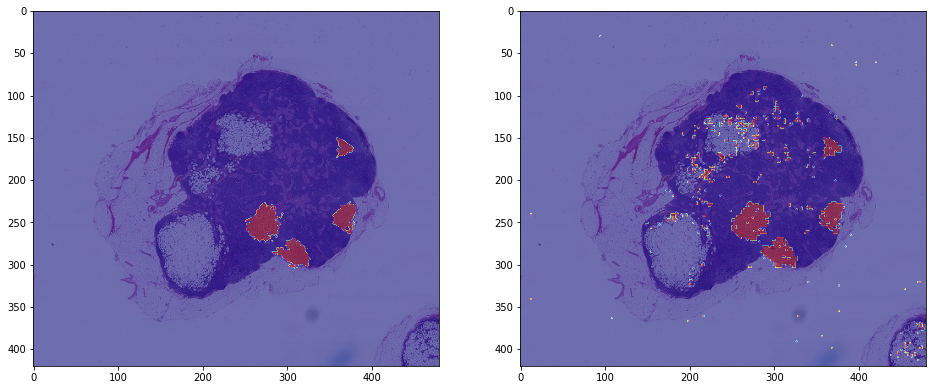

In [29]:
#4: multi_scale_inception_model_unfix
model_train_parameter = True
levels = level_list[1]
level_name = levelname_list[1]
print('model_train_parameter:', model_train_parameter, 'level:', levels)

roc_path = heatmap_result_save + level_name +'_multi_scale_inception_model_unfix_roc.png'
heatmap_path = heatmap_result_save + level_name +'_multi_scale_inception_model_unfix_heatmap.png'
heatmap_data_path = heatmap_result_save + level_name +'_multi_scale_inception_model_unfix_heatmap.npy'
result_path = heatmap_result_save + level_name +'_multi_scale_inception_model_unfix_result.csv'  
      
heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels = heatmap_prediction_one_time(slide, tumor_mask, levels = levels,model_train_parameter=model_train_parameter)

result = pd.DataFrame({'pred_prob': pred_probs_list, 'pred_label': pred_labels,'true_label':true_labels})
heatmap_evaluation(heatmap, pred_probs_list, pred_labels, true_labels, roc_path, heatmap_path)

# save
np.save(heatmap_data_path, heatmap)
result.to_csv(result_path)


## Predicting 8 times per patch and using mean prediction to plot the heatmap

In [ ]:
def predict_all_variations(batch_of_patches, model, if_single):
  '''
  Get the mean prediction prob of tumor, using all 8 variations of the input image including rotations and flipping
  '''
  pred_prob_dict = {}

  if if_single: # if it's for single-scale model prediction
    # original patches
    batch_of_patches_l1 = batch_of_patches[0]
    pred_prob_dict[1] = [prob_1 for (prob_0, prob_1) in model.predict(np.asarray(batch_of_patches_l1))]
    # flip
    batch_of_patches_l1 = [np.fliplr(img) for img in batch_of_patches_l1]
    pred_prob_dict[2] = [prob_1 for (prob_0, prob_1) in model.predict(np.asarray(batch_of_patches_l1))]
    
    for i in range(3,8,2):
      # rotate 90 degrees
      batch_of_patches_l1 = [np.rot90(img, 1) for img in batch_of_patches_l1]
      pred_prob_dict[i] = [prob_1 for (prob_0, prob_1) in model.predict(np.asarray(batch_of_patches_l1))]
      # flip
      batch_of_patches_l1 = [np.fliplr(img) for img in batch_of_patches_l1]
      pred_prob_dict[i+1] = [prob_1 for (prob_0, prob_1) in model.predict(np.asarray(batch_of_patches_l1))]

  else: # if it's for multi-scale model prediction
    # original patches
    batch_of_patches_l1 = batch_of_patches[0]
    batch_of_patches_l2 = batch_of_patches[1]
    pred_prob_dict[1] = [prob_1 for (prob_0, prob_1) in model.predict([np.asarray(batch_of_patches_l1), np.asarray(batch_of_patches_l2)])]
    # flip
    batch_of_patches_l1 = [np.fliplr(img) for img in batch_of_patches_l1]
    batch_of_patches_l2 = [np.fliplr(img) for img in batch_of_patches_l2]
    pred_prob_dict[2] = [prob_1 for (prob_0, prob_1) in model.predict([np.asarray(batch_of_patches_l1), np.asarray(batch_of_patches_l2)])]
    
    for i in range(3,8,2):
      # rotate 90 degrees
      batch_of_patches_l1 = [np.rot90(img, 1) for img in batch_of_patches_l1]
      batch_of_patches_l2 = [np.rot90(img, 1) for img in batch_of_patches_l2]
      pred_prob_dict[i] = [prob_1 for (prob_0, prob_1) in model.predict([np.asarray(batch_of_patches_l1), np.asarray(batch_of_patches_l2)])]
      # flip
      batch_of_patches_l1 = [np.fliplr(img) for img in batch_of_patches_l1]
      batch_of_patches_l2 = [np.fliplr(img) for img in batch_of_patches_l2]
      pred_prob_dict[i+1] = [prob_1 for (prob_0, prob_1) in model.predict([np.asarray(batch_of_patches_l1), np.asarray(batch_of_patches_l2)])]

  # calculate the mean prediction of the 8 variations of each image in the batch  
  mean_pred_batch = [sum(pred_prob_dict[k][i] for k in pred_prob_dict)/len(pred_prob_dict) for i in range(len(batch_of_patches_l1))]
  return mean_pred_batch

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score


def heatmap_prediction_eight_times(slide, tumor_mask, levels, size = 299, center_size = 128, model_train_parameter=False):
  # if it's multi-scale model prediction
  if len(levels) > 1:
    heatmap, heatmap_max, pred_probs_list, pred_labels, true_labels = heatmap_prediction_eight_times_multi_scale(slide, tumor_mask, levels, size, center_size, model_train_parameter)
  else:
    heatmap, heatmap_max, pred_probs_list, pred_labels, true_labels = heatmap_prediction_eight_times_single_scale(slide, tumor_mask, levels, size, center_size, model_train_parameter)
  return heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels

In [ ]:
def heatmap_prediction_eight_times_multi_scale(slide, tumor_mask, levels, size = 299, center_size = 128, model_train_parameter=False):
  """ 
  Predict a heatmap at scale level 7 for the input slide, using multi-scale model
  """
  
  thres = 0.5 # threshold of probability to decide a patch contains tumor
  plot_level = 7
  scale_factor_plot = 2**plot_level

  pred_labels = []
  true_labels = []

  heatmap_x_from_list = []
  heatmap_x_to_list = []
  heatmap_y_from_list = []
  heatmap_y_to_list = []
  pred_probs_list = []

  # each time collect a batch of patches to predict together (if one by one, running time too long; if all together, RAM will crash)
  prediction_batch_size = 50
  batch_of_patches = []

  # read in slide and tumor masks
  slide_image = read_slide(slide, x=0, y=0, level=plot_level,
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])
  mask_image = read_slide(tumor_mask, x=0, y=0, level=plot_level, 
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])[:,:,0]
  
  # get tissue pixels
  tissue_pixels = find_tissue_pixels(slide_image)

  # initialize the heatmap with zeros
  heatmap = np.zeros((slide.level_dimensions[plot_level][1],slide.level_dimensions[plot_level][0]))

  l1 = levels[0]
  scale_factor_l1 = 2**l1

  if model_train_parameter == False:
    model = multi_scale_inception_model
  else:
    model = multi_scale_inception_model_2
  
  l2 = levels[1]

  # get the slide size of model prediction level
  width_l1=slide.level_dimensions[l1][0]
  height_l1=slide.level_dimensions[l1][1]

  scale_factor_l2 = 2**l2
  half_patch_size = size //2

  # sliding a window through the image, step = center_size (= 128 by default) at 1st level in levels
  window_step = center_size * scale_factor_l1
  start_upper_left = (-(size - center_size)//2) * scale_factor_l1 # the start_x (== start_y) so that window's center part at (0,0)

  # to store l2 patches
  batch_of_patches_l2 = []

  for window_x in tqdm(range(start_upper_left, width_l1 * scale_factor_l1 - window_step, window_step)):
    for window_y in range(start_upper_left, height_l1 * scale_factor_l1 - window_step, window_step):

      # if this batch is full, predict them together, and clear this batch
      if len(batch_of_patches) == prediction_batch_size: 
        # predict the patches, and store the predicted probability of tumor
        pred_probs = predict_all_variations([batch_of_patches, batch_of_patches_l2], model, False)
        # pred_probs = [prob_1 for (prob_0, prob_1) in model.predict([np.asarray(batch_of_patches), np.asarray(batch_of_patches_l2)])]
        pred_probs_list += pred_probs
        for i in range(len(pred_probs)):
          prob = pred_probs[i]
          heatmap_x_from = heatmap_x_from_list[i]
          heatmap_y_from = heatmap_y_from_list[i]
          heatmap_x_to = heatmap_x_to_list[i]
          heatmap_y_to = heatmap_y_to_list[i]
          if prob >= thres:
            heatmap[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = 1
            pred_labels.append(1)
          else:
            pred_labels.append(0)
        # clear info for this batch to save RAM
        batch_of_patches = []
        batch_of_patches_l2 = []
        heatmap_x_from_list = []
        heatmap_y_from_list = []
        heatmap_x_to_list = []
        heatmap_y_to_list = []
        # print("Finished predicting a batch.")

      # if this batch is not full, continue to collect patches
      else:
        # get the l1 patch with upper-left corner at (window_x, window_y)
        patch_image_1, patch_mask_1 = get_a_patch_from_a_slide(slide, tumor_mask, window_x, window_y, size, level = l1)

        # only predict if it contains tissue in center region
        if center_contain_tissue(patch_image_1):
          # add this to the patches list
          img1 = preprocess_image(patch_image_1)
          batch_of_patches.append(img1)

          # get the true label of this patch
          true_label = get_true_label(patch_mask_1, size, center_size)
          true_labels.append(true_label)

          # calculate the upper-left coordinate for corresponding l2 slide, with same center as l1 patch
          center_coord = (window_x + (half_patch_size * scale_factor_l1), window_y + (half_patch_size * scale_factor_l1))
          upper_left_x_l2 = center_coord[0] - half_patch_size * scale_factor_l2
          upper_left_y_l2 = center_coord[1] - half_patch_size * scale_factor_l2
          
          # get the corresponding l2 patch
          patch_image_2, patch_mask_2 = get_a_patch_from_a_slide(slide, tumor_mask, upper_left_x_l2, upper_left_y_l2, size, level = l2)
          img2 = preprocess_image(patch_image_2)
          batch_of_patches_l2.append(img2)

          # store the area to color for this patch
          center_window_x = window_x + ((size-center_size)//2)*scale_factor_l1
          center_window_y = window_y + ((size-center_size)//2)*scale_factor_l1
          
          heatmap_x_from_list.append(round(center_window_x / scale_factor_plot))
          heatmap_x_to_list.append(round(round(center_window_x / scale_factor_plot) + center_size * scale_factor_l1 / scale_factor_plot))
          heatmap_y_from_list.append(round(center_window_y / scale_factor_plot))
          heatmap_y_to_list.append(round(round(center_window_y / scale_factor_plot) + center_size * scale_factor_l1 / scale_factor_plot))
  
  # predict the remaining patches in the current batch_of_patches
  pred_probs = predict_all_variations([batch_of_patches, batch_of_patches_l2], model, False)
  # pred_probs = [prob_1 for (prob_0, prob_1) in model.predict([np.asarray(batch_of_patches), np.asarray(batch_of_patches_l2)])]
  pred_probs_list += pred_probs
  for i in range(len(pred_probs)):
    prob = pred_probs[i]
    heatmap_x_from = heatmap_x_from_list[i]
    heatmap_y_from = heatmap_y_from_list[i]
    heatmap_x_to = heatmap_x_to_list[i]
    heatmap_y_to = heatmap_y_to_list[i]
    if prob >= thres:
      heatmap[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = 1
      pred_labels.append(1)
    else:
      pred_labels.append(0)
  # clear info for this batch to save RAM
  batch_of_patches = []
  heatmap_x_from_list = []
  heatmap_y_from_list = []
  heatmap_x_to_list = []
  heatmap_y_to_list = []
  print("Finished predicting all batches.")

  return heatmap, heatmap_max, pred_probs_list, pred_labels, true_labels

In [ ]:
def heatmap_prediction_eight_times_single_scale(slide, tumor_mask, levels, size = 299, center_size = 128, model_train_parameter=False):
  """ 
  Predict a heatmap at scale level 7 for the input slide, using single-scale model
  """
  
  thres = 0.5 # threshold of probability to decide a patch contains tumor
  plot_level = 7
  scale_factor_plot = 2**plot_level

  pred_labels = []
  true_labels = []

  heatmap_x_from_list = []
  heatmap_x_to_list = []
  heatmap_y_from_list = []
  heatmap_y_to_list = []
  pred_probs_list = []

  # each time collect a batch of patches to predict together (if one by one, running time too long; if all together, RAM will crash)
  prediction_batch_size = 50
  batch_of_patches = []

  # read in slide and tumor masks
  slide_image = read_slide(slide, x=0, y=0, level=plot_level,
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])
  mask_image = read_slide(tumor_mask, x=0, y=0, level=plot_level, 
                          width=slide.level_dimensions[plot_level][0], 
                          height=slide.level_dimensions[plot_level][1])[:,:,0]
  
  # get tissue pixels
  tissue_pixels = find_tissue_pixels(slide_image)

  # initialize the heatmap with zeros
  heatmap = np.zeros((slide.level_dimensions[plot_level][1],slide.level_dimensions[plot_level][0]))

  l1 = levels[0]
  scale_factor_l1 = 2**l1


  if model_train_parameter == False:
    model = single_scale_inception_model
  else:
    model = single_scale_inception_model_2

  # get the slide size of model prediction level
  width_l1=slide.level_dimensions[l1][0]
  height_l1=slide.level_dimensions[l1][1]

  half_patch_size = size //2

  # sliding a window through the image, step = center_size (= 128 by default) at 1st level in levels
  window_step = center_size * scale_factor_l1
  start_upper_left = (-(size - center_size)//2) * scale_factor_l1 # the start_x (== start_y) so that window's center part at (0,0)

  for window_x in tqdm(range(start_upper_left, width_l1 * scale_factor_l1 - window_step, window_step)):
    for window_y in range(start_upper_left, height_l1 * scale_factor_l1 - window_step, window_step):
      
      # if this batch is full, predict them together, and clear this batch
      if len(batch_of_patches) == prediction_batch_size: 
        # predict the patches, and store the predicted probability of tumor
        pred_probs = predict_all_variations([batch_of_patches], model, True)
        # pred_probs = [prob_1 for (prob_0, prob_1) in model.predict(np.asarray(batch_of_patches))]
        pred_probs_list += pred_probs
        for i in range(len(pred_probs)):
          prob = pred_probs[i]
          heatmap_x_from = heatmap_x_from_list[i]
          heatmap_y_from = heatmap_y_from_list[i]
          heatmap_x_to = heatmap_x_to_list[i]
          heatmap_y_to = heatmap_y_to_list[i]
          if prob >= thres:
            heatmap[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = 1
            pred_labels.append(1)
          else:
            pred_labels.append(0)
        # clear info for this batch to save RAM
        batch_of_patches = []
        heatmap_x_from_list = []
        heatmap_y_from_list = []
        heatmap_x_to_list = []
        heatmap_y_to_list = []
        # print("Finished predicting a batch.")

      # if this batch is not full, continue to collect patches
      else:
        # get the patch with upper-left corner at (window_x, window_y)
        patch_image_1, patch_mask_1 = get_a_patch_from_a_slide(slide, tumor_mask, window_x, window_y, size, level = l1)

        # only predict it if its center region contains tissue
        if center_contain_tissue(patch_image_1):
          # add this to the patches list
          img = preprocess_image(patch_image_1)
          batch_of_patches.append(img)

          # get the true label of this patch
          true_label = get_true_label(patch_mask_1, size, center_size)
          true_labels.append(true_label)

          # store the area to color for this patch
          center_window_x = window_x + ((size-center_size)//2)*scale_factor_l1
          center_window_y = window_y + ((size-center_size)//2)*scale_factor_l1
          
          heatmap_x_from_list.append(round(center_window_x / scale_factor_plot))
          heatmap_x_to_list.append(round(round(center_window_x / scale_factor_plot) + center_size * scale_factor_l1 / scale_factor_plot))
          heatmap_y_from_list.append(round(center_window_y / scale_factor_plot))
          heatmap_y_to_list.append(round(round(center_window_y / scale_factor_plot) + center_size * scale_factor_l1 / scale_factor_plot))

  # predict the remaining patches in the current batch_of_patches
  pred_probs = predict_all_variations([batch_of_patches], model, True)
  # pred_probs = [prob_1 for (prob_0, prob_1) in model.predict(np.asarray(batch_of_patches))]
  pred_probs_list += pred_probs
  for i in range(len(pred_probs)):
    prob = pred_probs[i]
    heatmap_x_from = heatmap_x_from_list[i]
    heatmap_y_from = heatmap_y_from_list[i]
    heatmap_x_to = heatmap_x_to_list[i]
    heatmap_y_to = heatmap_y_to_list[i]
    if prob >= thres:
      heatmap[heatmap_y_from : heatmap_y_to, heatmap_x_from: heatmap_x_to] = 1
      pred_labels.append(1)
    else:
      pred_labels.append(0)
  # clear info for this batch to save RAM
  batch_of_patches = []
  heatmap_x_from_list = []
  heatmap_y_from_list = []
  heatmap_x_to_list = []
  heatmap_y_to_list = []
  print("Finished predicting all batches.")

  return heatmap, heatmap_max, pred_probs_list, pred_labels, true_labels

In [ ]:
# # predict 8 times: single_scale_inception_model_unfix
# model_train_parameter = True
# levels = level_list[0]
# level_name = levelname_list[0]
# print('model_train_parameter:', model_train_parameter, 'level:', levels)

# roc_path = heatmap_result_save + level_name +'_single_scale_inception_model_unfix_roc_8times.png'
# heatmap_path = heatmap_result_save + level_name +'_single_scale_inception_model_unfix_heatmap_8times.png'
# heatmap_data_path = heatmap_result_save + level_name +'_single_scale_inception_model_unfix_heatmap_8times.npy'
# result_path = heatmap_result_save + level_name +'_single_scale_inception_model_unfix_result_8times.csv'  
      
# heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels = heatmap_prediction_eight_times(slide, tumor_mask, levels = levels, model_train_parameter=model_train_parameter)

# result = pd.DataFrame({'pred_prob': pred_probs_list, 'pred_label': pred_labels,'true_label':true_labels})
# heatmap_evaluation(heatmap, pred_probs_list, pred_labels, true_labels, roc_path, heatmap_path)

# # save
# np.save(heatmap_data_path, heatmap)
# result.to_csv(result_path)

In [ ]:
# # predict 8 times: multi_scale_inception_model_unfix
# model_train_parameter = True
# levels = level_list[1]
# level_name = levelname_list[1]
# print('model_train_parameter:', model_train_parameter, 'level:', levels)

# roc_path = heatmap_result_save + level_name +'_multi_scale_inception_model_unfix_roc_8times.png'
# heatmap_path = heatmap_result_save + level_name +'_multi_scale_inception_model_unfix_heatmap_8times.png'
# heatmap_data_path = heatmap_result_save + level_name +'_multi_scale_inception_model_unfix_heatmap_8times.npy'
# result_path = heatmap_result_save + level_name +'_multi_scale_inception_model_unfix_result_8times.csv'  
      
# heatmap, heatmap_prob, pred_probs_list, pred_labels, true_labels = heatmap_prediction_eight_times(slide, tumor_mask, levels = levels, model_train_parameter=model_train_parameter)

# result = pd.DataFrame({'pred_prob': pred_probs_list, 'pred_label': pred_labels,'true_label':true_labels})
# heatmap_evaluation(heatmap, pred_probs_list, pred_labels, true_labels, roc_path, heatmap_path)

# # save
# np.save(heatmap_data_path, heatmap)
# result.to_csv(result_path)